<a href="https://colab.research.google.com/github/seansothey/Research_Project/blob/main/Diabetic_Retinopath_Detection_CNN(subset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data

**Machine Learning Techniques:** 


*   CNN 1, 3 and 5 layers
*   Max-Pooling
*   Data Augumentation

**Additionl Tools:**


*   Github & Kaggle: for hosting datasets and python notebook
*   Tableau: for report visualization









#Setup

In [ ]:
#!pip install tensorflow-gpu

In [1]:
!nvidia-smi

Thu Oct 15 03:51:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/train005.zip"

In [5]:
DR_data = os.listdir('/content/train')

In [6]:
len(DR_data)

1427

###Create the images dataset

In [7]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(256,256)) # resize images
    x.append(np.array(img_imr))
  return x

In [8]:
data = create_img_set(os.path.join('/content/train'))

Show some images

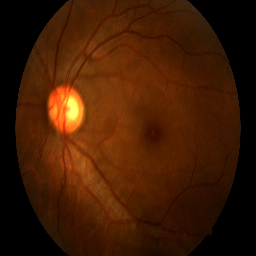

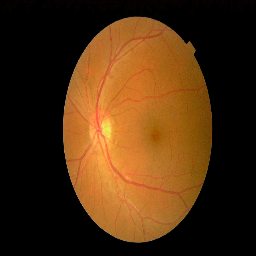

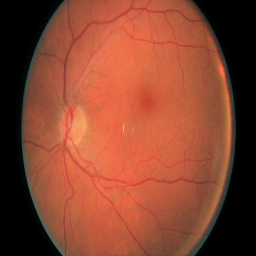

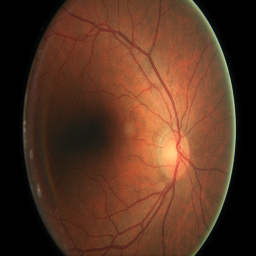

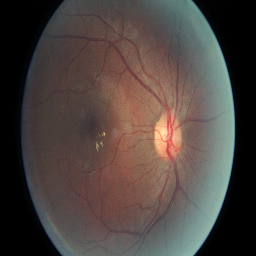

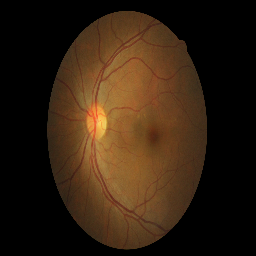

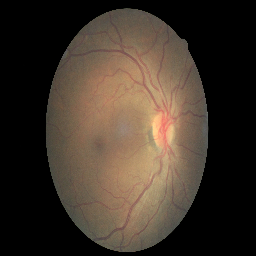

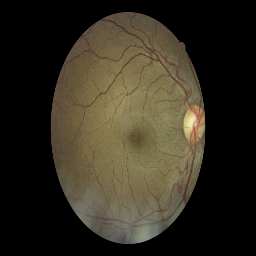

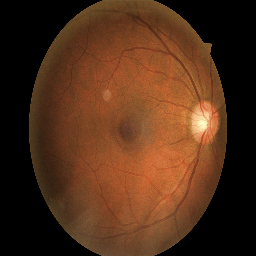

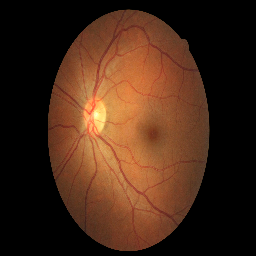

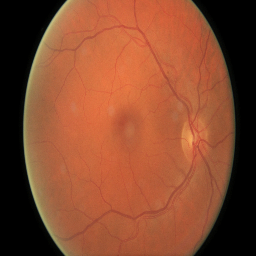

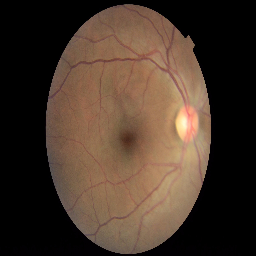

In [9]:
for i in range(0,12):
  cv2_imshow(data[i])

###Flattening the images dataset

In [10]:
data_flatten = np.array(data)

In [11]:
data_flatten.shape

(1427, 256, 256, 3)

###Scale the dataset

In [12]:
np.amax(data_flatten) # See the maximum value before scale

255

Scale to (0,1) by deviding with max. value 255

In [13]:
data_scale = data_flatten.astype('float32')/255.0

###Create label y

In [14]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [15]:
all_label

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Let's check if the classes are balanced

In [16]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Because we only use subset 1427 images; therefore, we have to extract assiciated label correctly.

In [17]:
label = []

In [18]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [19]:
label = pd.DataFrame(label,columns=['image'])

In [67]:
label

,image
0,8834_left
1,8511_left
2,8878_right
3,9665_left
4,9893_left
...,...
1422,9796_right
1423,9667_right
1424,9025_left
1425,9626_right


In [20]:
new_label = pd.merge(label, all_label, on=['image'])

In [21]:
new_label

,image,level
0,8834_left,0
1,8511_left,0
2,8878_right,0
3,9665_left,0
4,9893_left,2
...,...,...
1422,9796_right,0
1423,9667_right,0
1424,9025_left,0
1425,9626_right,0


Check the balance of the classes

In [22]:
print(new_label.groupby('level').nunique())

       image
level       
0       1017
1        112
2        230
3         32
4         36


We can see, the subset contents imbalance clasess.

Let's verify with first and last file name to see if it's matched.

In [23]:
DR_data[0], new_label['image'][0]

('8834_left.jpeg', '8834_left')

In [25]:
DR_data[500], new_label['image'][500]

('9003_left.jpeg', '9003_left')

In [26]:
DR_data[1000], new_label['image'][1000]

('990_left.jpeg', '990_left')

Therefore, the new label is created correctly and good to go!!!

In [27]:
target = new_label['level']

Split training and testing set 80:20

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_scale, target, test_size=0.3, random_state=42)

In [29]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [30]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [31]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

##CNN 5-layers 

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
import tensorflow as tf
print(tf.__version__)

np.random.seed(168)

2.3.0


Instantiate some optimizers

In [33]:
sgd = optimizers.SGD(learning_rate=0.01)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [34]:
cnn5 = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(2,2), input_shape=(256,256,3)),  # 1st layer
    MaxPooling2D(pool_size=(2, 2),strides=2),

    Conv2D(32, kernel_size=(3,3), activation='relu'), # 2nd layer
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),

    Conv2D(32, kernel_size=(3,3), activation='relu',  kernel_regularizer=regularizers.l2(0.01)), # 3rd layer
    MaxPooling2D(pool_size=(2,2), strides=2),
    Dropout(0.2),

    Conv2D(16, kernel_size=(3,3), activation='relu'), # 4th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    BatchNormalization(),

    Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), # 5th layer
    MaxPooling2D(pool_size=(2,2), strides=1),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [35]:
#For Classification use 'categorical_crossentropy' or 'binary_crossentropy'
#For Regression use 'mean_square_error'
cnn5.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [36]:
cnn5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0

###Training the model

In [37]:
tr5 = cnn5.fit(X_train, y_train_cat, 
          batch_size=50, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 1s 42ms/step - loss: 1.5591 - accuracy: 0.6629 - val_loss: 2.0070 - val_accuracy: 0.7400
Epoch 2/20
16/16 [==============================] - 0s 23ms/step - loss: 1.4062 - accuracy: 0.7055 - val_loss: 1.9301 - val_accuracy: 0.7400
Epoch 3/20
16/16 [==============================] - 0s 24ms/step - loss: 1.4090 - accuracy: 0.7093 - val_loss: 1.8499 - val_accuracy: 0.7400
Epoch 4/20
16/16 [==============================] - 0s 23ms/step - loss: 1.3866 - accuracy: 0.7093 - val_loss: 1.7778 - val_accuracy: 0.7400
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 1.3887 - accuracy: 0.7093 - val_loss: 1.6805 - val_accuracy: 0.7400
Epoch 6/20
16/16 [==============================] - 0s 23ms/step - loss: 1.3786 - accuracy: 0.7093 - val_loss: 1.6168 - val_accuracy: 0.7400
Epoch 7/20
16/16 [==============================] - 0s 23ms/step - loss: 1.3837 - accuracy: 0.7093 - val_loss: 1.5835 - val_accuracy: 0.7400
Epoch 8/20
16

###See the accuracy

In [38]:
score5 = cnn5.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score5[0])
print('Test accuracy:', score5[1])

Test loss: 1.379091501235962
Test accuracy: 0.7062937021255493


It's very low, let's try some more layers and augument dataset.

###See the prediction

In [39]:
pred_test = cnn5.predict_classes(X_test, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


###Plot the learning curve

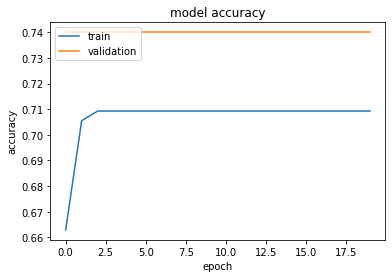

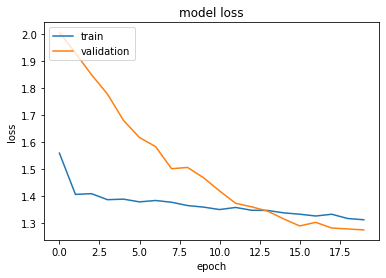

In [41]:
plt.plot(tr5.history['accuracy'])
plt.plot(tr5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr5.history['loss'])
plt.plot(tr5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
# Save the model as h5 file
from tensorflow.keras.models import load_model
cnn5.save('CNN5_Layers.h5')

###Classification Report

In [43]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.71      1.00      0.83       303
            Mild       0.00      0.00      0.00        39
        Moderate       0.00      0.00      0.00        61
          Severe       0.00      0.00      0.00        13
Proliferative DR       0.00      0.00      0.00        13

        accuracy                           0.71       429
       macro avg       0.14      0.20      0.17       429
    weighted avg       0.50      0.71      0.58       429



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

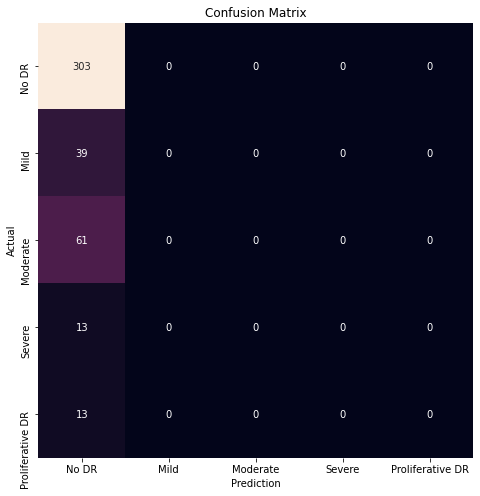

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

##Tuning hyperparameters with Keras Tuner

In [ ]:
!pip install keras-tuner

In [49]:
import tensorflow as tf
import kerastuner as kt

In [50]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [51]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    executions_per_trial=2,
    directory='Hyperband',
    project_name='Face_Expression')

In [52]:
tuner.search(X_train, y_train_cat,
             validation_split=0.2, 
             epochs=10)

Epoch 1/2
25/25 [==============================] - 10s 412ms/step - loss: 1.5628 - accuracy: 0.2118 - val_loss: 1.5855 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 8s 335ms/step - loss: 1.3697 - accuracy: 0.6128 - val_loss: 1.5238 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 9s 345ms/step - loss: 1.5278 - accuracy: 0.3358 - val_loss: 1.6114 - val_accuracy: 0.1450
Epoch 2/2
25/25 [==============================] - 8s 337ms/step - loss: 1.3170 - accuracy: 0.6867 - val_loss: 1.5636 - val_accuracy: 0.1700


Epoch 1/2
25/25 [==============================] - 7s 299ms/step - loss: 1.4515 - accuracy: 0.4211 - val_loss: 1.4816 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 6s 234ms/step - loss: 1.1388 - accuracy: 0.7030 - val_loss: 1.1434 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 6s 246ms/step - loss: 1.5044 - accuracy: 0.4211 - val_loss: 1.4758 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 6s 235ms/step - loss: 1.1143 - accuracy: 0.7093 - val_loss: 1.1395 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 5s 182ms/step - loss: 1.0686 - accuracy: 0.6704 - val_loss: 1.0051 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 3s 138ms/step - loss: 0.9430 - accuracy: 0.7093 - val_loss: 0.9505 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 4s 146ms/step - loss: 1.0883 - accuracy: 0.6754 - val_loss: 9.2734 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 3s 138ms/step - loss: 0.9552 - accuracy: 0.7093 - val_loss: 1.1414 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 7s 277ms/step - loss: 1.1181 - accuracy: 0.6115 - val_loss: 1.6077 - val_accuracy: 0.1450
Epoch 2/2
25/25 [==============================] - 5s 217ms/step - loss: 0.9791 - accuracy: 0.6992 - val_loss: 1.5539 - val_accuracy: 0.1450
Epoch 1/2
25/25 [==============================] - 6s 226ms/step - loss: 1.5436 - accuracy: 0.4323 - val_loss: 1.6867 - val_accuracy: 0.0100
Epoch 2/2
25/25 [==============================] - 5s 217ms/step - loss: 1.0615 - accuracy: 0.7005 - val_loss: 1.7047 - val_accuracy: 0.0100


Epoch 1/2
25/25 [==============================] - 15s 588ms/step - loss: 1.0551 - accuracy: 0.6617 - val_loss: 3.7147 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 12s 478ms/step - loss: 0.9163 - accuracy: 0.7093 - val_loss: 1.2846 - val_accuracy: 0.3400
Epoch 1/2
25/25 [==============================] - 12s 488ms/step - loss: 1.0364 - accuracy: 0.6617 - val_loss: 2.1322 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 12s 478ms/step - loss: 0.9193 - accuracy: 0.7093 - val_loss: 1.1193 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 4s 176ms/step - loss: 1.1506 - accuracy: 0.6654 - val_loss: 305.8214 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 4s 156ms/step - loss: 0.9643 - accuracy: 0.7068 - val_loss: 10.3343 - val_accuracy: 0.7450
Epoch 1/2
25/25 [==============================] - 4s 162ms/step - loss: 1.0602 - accuracy: 0.6717 - val_loss: 59.5504 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 4s 152ms/step - loss: 0.9664 - accuracy: 0.7030 - val_loss: 10.3484 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 4s 173ms/step - loss: 1.0720 - accuracy: 0.6391 - val_loss: 1.2876 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 4s 151ms/step - loss: 0.9709 - accuracy: 0.6967 - val_loss: 1.1194 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 4s 161ms/step - loss: 1.2184 - accuracy: 0.6115 - val_loss: 1.4297 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 4s 151ms/step - loss: 0.9806 - accuracy: 0.7043 - val_loss: 1.2164 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 8s 337ms/step - loss: 1.0261 - accuracy: 0.6942 - val_loss: 30.9622 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 7s 286ms/step - loss: 0.9280 - accuracy: 0.7080 - val_loss: 6.9203 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 7s 297ms/step - loss: 1.0534 - accuracy: 0.6767 - val_loss: 40.3626 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 7s 287ms/step - loss: 0.9534 - accuracy: 0.7030 - val_loss: 8.6062 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 10s 382ms/step - loss: 1.0832 - accuracy: 0.6591 - val_loss: 132.8979 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 9s 352ms/step - loss: 0.9629 - accuracy: 0.6992 - val_loss: 5.0184 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 9s 361ms/step - loss: 1.2035 - accuracy: 0.6165 - val_loss: 90.1188 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 9s 351ms/step - loss: 0.9631 - accuracy: 0.7068 - val_loss: 2.5219 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 18s 702ms/step - loss: 1.2320 - accuracy: 0.5514 - val_loss: 1.5049 - val_accuracy: 0.4100
Epoch 2/2
25/25 [==============================] - 15s 580ms/step - loss: 1.0349 - accuracy: 0.6792 - val_loss: 1.3335 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 15s 587ms/step - loss: 1.1899 - accuracy: 0.5915 - val_loss: 1.6282 - val_accuracy: 0.0650
Epoch 2/2
25/25 [==============================] - 14s 577ms/step - loss: 1.0537 - accuracy: 0.6855 - val_loss: 1.5618 - val_accuracy: 0.0800


Epoch 1/2
25/25 [==============================] - 14s 555ms/step - loss: 1.0522 - accuracy: 0.6817 - val_loss: 342.8619 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 13s 536ms/step - loss: 0.9253 - accuracy: 0.7093 - val_loss: 9.5082 - val_accuracy: 0.7400
Epoch 1/2
25/25 [==============================] - 14s 546ms/step - loss: 1.0456 - accuracy: 0.6667 - val_loss: 125.5207 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 13s 537ms/step - loss: 0.9287 - accuracy: 0.7093 - val_loss: 9.9308 - val_accuracy: 0.7400


Epoch 1/2
25/25 [==============================] - 3s 107ms/step - loss: 1.0413 - accuracy: 0.6967 - val_loss: 51.2110 - val_accuracy: 0.6850
Epoch 2/2
25/25 [==============================] - 2s 77ms/step - loss: 0.9413 - accuracy: 0.7093 - val_loss: 4.5786 - val_accuracy: 0.3600
Epoch 1/2
25/25 [==============================] - 2s 89ms/step - loss: 1.0626 - accuracy: 0.6867 - val_loss: 13.4911 - val_accuracy: 0.7400
Epoch 2/2
25/25 [==============================] - 2s 79ms/step - loss: 0.9421 - accuracy: 0.7093 - val_loss: 1.5302 - val_accuracy: 0.7450


Epoch 3/4
25/25 [==============================] - 4s 167ms/step - loss: 1.1116 - accuracy: 0.6830 - val_loss: 204.9505 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 4s 153ms/step - loss: 0.9769 - accuracy: 0.7080 - val_loss: 8.0982 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 4s 163ms/step - loss: 1.1018 - accuracy: 0.6591 - val_loss: 123.5030 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 4s 152ms/step - loss: 0.9770 - accuracy: 0.7068 - val_loss: 7.6394 - val_accuracy: 0.7400


Epoch 3/4
25/25 [==============================] - 6s 250ms/step - loss: 1.3054 - accuracy: 0.5714 - val_loss: 1.2951 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 6s 235ms/step - loss: 1.0049 - accuracy: 0.7105 - val_loss: 0.9944 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 6s 246ms/step - loss: 1.4599 - accuracy: 0.4612 - val_loss: 1.4900 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 6s 235ms/step - loss: 1.1096 - accuracy: 0.7080 - val_loss: 1.0583 - val_accuracy: 0.7400


Epoch 3/4
25/25 [==============================] - 4s 149ms/step - loss: 1.1125 - accuracy: 0.6591 - val_loss: 26.5084 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 3s 138ms/step - loss: 0.9699 - accuracy: 0.6980 - val_loss: 1.9932 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 4s 147ms/step - loss: 1.0503 - accuracy: 0.6767 - val_loss: 3.9537 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 3s 138ms/step - loss: 0.9568 - accuracy: 0.7080 - val_loss: 1.1478 - val_accuracy: 0.7400


Epoch 3/4
25/25 [==============================] - 12s 491ms/step - loss: 1.0500 - accuracy: 0.6604 - val_loss: 2.6615 - val_accuracy: 0.0950
Epoch 4/4
25/25 [==============================] - 12s 482ms/step - loss: 0.9283 - accuracy: 0.7080 - val_loss: 1.0561 - val_accuracy: 0.7350
Epoch 3/4
25/25 [==============================] - 12s 492ms/step - loss: 1.0561 - accuracy: 0.6617 - val_loss: 5.1371 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 12s 479ms/step - loss: 0.9237 - accuracy: 0.7093 - val_loss: 1.3654 - val_accuracy: 0.3450


Epoch 5/10
25/25 [==============================] - 4s 166ms/step - loss: 1.1696 - accuracy: 0.6491 - val_loss: 69.0897 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9827 - accuracy: 0.7043 - val_loss: 1.4896 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9684 - accuracy: 0.7030 - val_loss: 1.8175 - val_accuracy: 0.7400
Epoch 8/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9659 - accuracy: 0.7068 - val_loss: 0.9229 - val_accuracy: 0.7400
Epoch 9/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9441 - accuracy: 0.7093 - val_loss: 0.8777 - val_accuracy: 0.7400
Epoch 10/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9429 - accuracy: 0.7093 - val_loss: 0.8812 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 4s 164ms/step - loss: 1.1312 - accuracy: 0.6516 - val_loss: 278.3080 - val_accuracy: 0.7400
Ep

Epoch 5/10
25/25 [==============================] - 6s 250ms/step - loss: 1.3567 - accuracy: 0.5551 - val_loss: 1.4358 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 6s 236ms/step - loss: 1.0782 - accuracy: 0.7093 - val_loss: 1.1384 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 6s 235ms/step - loss: 0.9753 - accuracy: 0.7080 - val_loss: 0.9053 - val_accuracy: 0.7400
Epoch 8/10
25/25 [==============================] - 6s 235ms/step - loss: 0.9540 - accuracy: 0.7093 - val_loss: 0.9103 - val_accuracy: 0.7400
Epoch 9/10
25/25 [==============================] - 6s 236ms/step - loss: 0.9290 - accuracy: 0.7093 - val_loss: 0.8616 - val_accuracy: 0.7400
Epoch 10/10
25/25 [==============================] - 6s 236ms/step - loss: 0.9303 - accuracy: 0.7093 - val_loss: 0.8901 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 6s 247ms/step - loss: 1.3001 - accuracy: 0.5815 - val_loss: 1.3633 - val_accuracy: 0.7400
Epoch

Epoch 1/4
25/25 [==============================] - 12s 499ms/step - loss: 1.0480 - accuracy: 0.6729 - val_loss: 3.3430 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 12s 474ms/step - loss: 0.9598 - accuracy: 0.7030 - val_loss: 1.8246 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 12s 475ms/step - loss: 0.9422 - accuracy: 0.7043 - val_loss: 1.5068 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 12s 474ms/step - loss: 0.9283 - accuracy: 0.7030 - val_loss: 1.7398 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 12s 485ms/step - loss: 1.0756 - accuracy: 0.6692 - val_loss: 1.3265 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 12s 474ms/step - loss: 0.9413 - accuracy: 0.7080 - val_loss: 0.9434 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 12s 474ms/step - loss: 0.9524 - accuracy: 0.7030 - val_loss: 1.1050 - val_accuracy: 0.7400
Epoch 

Epoch 1/4
25/25 [==============================] - 13s 533ms/step - loss: 1.2596 - accuracy: 0.5927 - val_loss: 1.4867 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 12s 499ms/step - loss: 1.0811 - accuracy: 0.6930 - val_loss: 1.3440 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 12s 500ms/step - loss: 1.0361 - accuracy: 0.7005 - val_loss: 1.2883 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 12s 498ms/step - loss: 1.0027 - accuracy: 0.7005 - val_loss: 1.0912 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 13s 509ms/step - loss: 1.1837 - accuracy: 0.5965 - val_loss: 1.5212 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 12s 500ms/step - loss: 1.0713 - accuracy: 0.6566 - val_loss: 1.2708 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 12s 499ms/step - loss: 0.9998 - accuracy: 0.6867 - val_loss: 1.2284 - val_accuracy: 0.7400
Epoch 

Epoch 1/4
25/25 [==============================] - 6s 257ms/step - loss: 1.1052 - accuracy: 0.6391 - val_loss: 3.7582 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 6s 230ms/step - loss: 0.9438 - accuracy: 0.7055 - val_loss: 1.5777 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 6s 230ms/step - loss: 0.9482 - accuracy: 0.7080 - val_loss: 0.9129 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 6s 229ms/step - loss: 0.9329 - accuracy: 0.7080 - val_loss: 0.9386 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 6s 239ms/step - loss: 1.0868 - accuracy: 0.6504 - val_loss: 1.7768 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 6s 230ms/step - loss: 0.9907 - accuracy: 0.7055 - val_loss: 1.1362 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 6s 230ms/step - loss: 0.9527 - accuracy: 0.7068 - val_loss: 0.8626 - val_accuracy: 0.7400
Epoch 4/4
25/

Epoch 1/4
25/25 [==============================] - 12s 479ms/step - loss: 1.0564 - accuracy: 0.6767 - val_loss: 4.7175 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 10s 405ms/step - loss: 0.9871 - accuracy: 0.7093 - val_loss: 1.0424 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 10s 405ms/step - loss: 0.9678 - accuracy: 0.7093 - val_loss: 0.9002 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 10s 405ms/step - loss: 0.9543 - accuracy: 0.7093 - val_loss: 0.8541 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 10s 414ms/step - loss: 1.0163 - accuracy: 0.6955 - val_loss: 28.7645 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 10s 405ms/step - loss: 0.9896 - accuracy: 0.6955 - val_loss: 1.9113 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 10s 405ms/step - loss: 0.9501 - accuracy: 0.7093 - val_loss: 0.8980 - val_accuracy: 0.7400
Epoch

Epoch 1/4
25/25 [==============================] - 14s 559ms/step - loss: 1.2229 - accuracy: 0.6466 - val_loss: 1138.2859 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 13s 529ms/step - loss: 1.0235 - accuracy: 0.6955 - val_loss: 73.2883 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 13s 530ms/step - loss: 0.9691 - accuracy: 0.7093 - val_loss: 3.4134 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 13s 529ms/step - loss: 0.9674 - accuracy: 0.7093 - val_loss: 1.0754 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 13s 539ms/step - loss: 1.1894 - accuracy: 0.6742 - val_loss: 11089.2725 - val_accuracy: 0.0250
Epoch 2/4
25/25 [==============================] - 13s 530ms/step - loss: 0.9867 - accuracy: 0.7080 - val_loss: 26.1657 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 13s 530ms/step - loss: 0.9483 - accuracy: 0.7093 - val_loss: 7.4987 - val_accuracy: 0.74

Epoch 1/4
25/25 [==============================] - 9s 362ms/step - loss: 1.0573 - accuracy: 0.6642 - val_loss: 17.1871 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 8s 340ms/step - loss: 0.9274 - accuracy: 0.7093 - val_loss: 0.9495 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 8s 338ms/step - loss: 0.9239 - accuracy: 0.7093 - val_loss: 1.0206 - val_accuracy: 0.7400
Epoch 4/4
25/25 [==============================] - 8s 339ms/step - loss: 0.9260 - accuracy: 0.7093 - val_loss: 0.9085 - val_accuracy: 0.7400
Epoch 1/4
25/25 [==============================] - 9s 348ms/step - loss: 1.0658 - accuracy: 0.6667 - val_loss: 32.3999 - val_accuracy: 0.7400
Epoch 2/4
25/25 [==============================] - 8s 338ms/step - loss: 0.9383 - accuracy: 0.7093 - val_loss: 3.3502 - val_accuracy: 0.7400
Epoch 3/4
25/25 [==============================] - 8s 338ms/step - loss: 0.9158 - accuracy: 0.7093 - val_loss: 0.9332 - val_accuracy: 0.7400
Epoch 4/4
2

Epoch 5/10
25/25 [==============================] - 12s 486ms/step - loss: 1.0672 - accuracy: 0.6742 - val_loss: 1.7564 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 12s 475ms/step - loss: 0.9706 - accuracy: 0.7093 - val_loss: 1.4163 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 12s 474ms/step - loss: 0.9503 - accuracy: 0.7080 - val_loss: 0.9497 - val_accuracy: 0.7400
Epoch 8/10
25/25 [==============================] - 12s 474ms/step - loss: 0.9273 - accuracy: 0.7080 - val_loss: 0.9359 - val_accuracy: 0.7400
Epoch 9/10
25/25 [==============================] - 12s 475ms/step - loss: 0.9374 - accuracy: 0.7093 - val_loss: 0.8573 - val_accuracy: 0.7400
Epoch 10/10
25/25 [==============================] - 12s 474ms/step - loss: 0.9353 - accuracy: 0.7093 - val_loss: 0.8524 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 12s 483ms/step - loss: 1.0832 - accuracy: 0.6591 - val_loss: 1.9203 - val_accuracy: 0.740

Epoch 5/10
25/25 [==============================] - 13s 513ms/step - loss: 1.2370 - accuracy: 0.5501 - val_loss: 1.5043 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 12s 499ms/step - loss: 1.0483 - accuracy: 0.6805 - val_loss: 1.4196 - val_accuracy: 0.4950
Epoch 7/10
25/25 [==============================] - 12s 499ms/step - loss: 1.0104 - accuracy: 0.6867 - val_loss: 1.1656 - val_accuracy: 0.7400
Epoch 8/10
25/25 [==============================] - 12s 500ms/step - loss: 0.9930 - accuracy: 0.6955 - val_loss: 1.1422 - val_accuracy: 0.7400
Epoch 9/10
25/25 [==============================] - 12s 500ms/step - loss: 0.9778 - accuracy: 0.7018 - val_loss: 1.0055 - val_accuracy: 0.7400
Epoch 10/10
25/25 [==============================] - 12s 500ms/step - loss: 0.9632 - accuracy: 0.7030 - val_loss: 0.9791 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 13s 510ms/step - loss: 1.2488 - accuracy: 0.6003 - val_loss: 1.5361 - val_accuracy: 0.080

Epoch 1/10
25/25 [==============================] - 10s 402ms/step - loss: 1.2907 - accuracy: 0.5476 - val_loss: 1.4468 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 10s 382ms/step - loss: 0.9990 - accuracy: 0.7005 - val_loss: 1.2585 - val_accuracy: 0.7400
Epoch 3/10
25/25 [==============================] - 10s 382ms/step - loss: 0.9759 - accuracy: 0.7018 - val_loss: 1.0859 - val_accuracy: 0.7400
Epoch 4/10
25/25 [==============================] - 10s 382ms/step - loss: 0.9557 - accuracy: 0.7068 - val_loss: 1.0517 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 10s 383ms/step - loss: 0.9323 - accuracy: 0.7055 - val_loss: 0.9183 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 10s 383ms/step - loss: 0.9298 - accuracy: 0.7068 - val_loss: 0.8803 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 10s 382ms/step - loss: 0.9281 - accuracy: 0.7068 - val_loss: 0.8907 - val_accuracy: 0.7400

Epoch 1/10
25/25 [==============================] - 10s 395ms/step - loss: 1.1671 - accuracy: 0.6165 - val_loss: 1.2976 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 9s 376ms/step - loss: 1.0279 - accuracy: 0.6892 - val_loss: 1.2941 - val_accuracy: 0.7400
Epoch 3/10
25/25 [==============================] - 9s 376ms/step - loss: 0.9929 - accuracy: 0.6905 - val_loss: 0.8870 - val_accuracy: 0.7400
Epoch 4/10
25/25 [==============================] - 9s 376ms/step - loss: 0.9932 - accuracy: 0.7005 - val_loss: 0.9445 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 9s 377ms/step - loss: 0.9386 - accuracy: 0.7018 - val_loss: 0.8968 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 9s 377ms/step - loss: 0.9591 - accuracy: 0.7043 - val_loss: 0.8507 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 9s 377ms/step - loss: 0.9776 - accuracy: 0.7043 - val_loss: 0.8659 - val_accuracy: 0.7400
Epoch

Epoch 1/10
25/25 [==============================] - 4s 172ms/step - loss: 1.6330 - accuracy: 0.2794 - val_loss: 1.6386 - val_accuracy: 0.0100
Epoch 2/10
25/25 [==============================] - 4s 154ms/step - loss: 1.2482 - accuracy: 0.6316 - val_loss: 1.6352 - val_accuracy: 0.0100
Epoch 3/10
25/25 [==============================] - 4s 157ms/step - loss: 1.0927 - accuracy: 0.6892 - val_loss: 1.6160 - val_accuracy: 0.0300
Epoch 4/10
25/25 [==============================] - 4s 156ms/step - loss: 1.0233 - accuracy: 0.7005 - val_loss: 1.5803 - val_accuracy: 0.5150
Epoch 5/10
25/25 [==============================] - 4s 156ms/step - loss: 1.0152 - accuracy: 0.7043 - val_loss: 1.5290 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 4s 154ms/step - loss: 0.9767 - accuracy: 0.7018 - val_loss: 1.4886 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 4s 153ms/step - loss: 0.9667 - accuracy: 0.7018 - val_loss: 1.4389 - val_accuracy: 0.7400
Epoch 

Epoch 1/10
25/25 [==============================] - 10s 387ms/step - loss: 1.1976 - accuracy: 0.6153 - val_loss: 10.4774 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 9s 364ms/step - loss: 1.0011 - accuracy: 0.7005 - val_loss: 1.7381 - val_accuracy: 0.7400
Epoch 3/10
25/25 [==============================] - 9s 364ms/step - loss: 0.9525 - accuracy: 0.7043 - val_loss: 0.9417 - val_accuracy: 0.7400
Epoch 4/10
25/25 [==============================] - 9s 365ms/step - loss: 0.9421 - accuracy: 0.7093 - val_loss: 1.1016 - val_accuracy: 0.4150
Epoch 5/10
25/25 [==============================] - 9s 365ms/step - loss: 0.9574 - accuracy: 0.7080 - val_loss: 0.9214 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 9s 365ms/step - loss: 0.9266 - accuracy: 0.7118 - val_loss: 1.0328 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 9s 365ms/step - loss: 0.9570 - accuracy: 0.7068 - val_loss: 0.8767 - val_accuracy: 0.7400
Epoc

INFO:tensorflow:Oracle triggered exit


In [53]:
model = tuner.get_best_models(num_models=1)[0]

In [54]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 96)      2688      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 96)      384       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 96)      83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 96)      384       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 96)     

In [55]:
model.fit(X_train, y_train_cat, epochs=10, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 4s 167ms/step - loss: 0.9575 - accuracy: 0.7080 - val_loss: 1.0854 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 4s 156ms/step - loss: 0.9679 - accuracy: 0.7068 - val_loss: 1.2155 - val_accuracy: 0.2050
Epoch 3/10
25/25 [==============================] - 4s 156ms/step - loss: 0.9536 - accuracy: 0.7080 - val_loss: 1.1200 - val_accuracy: 0.7400
Epoch 4/10
25/25 [==============================] - 4s 156ms/step - loss: 0.9361 - accuracy: 0.7080 - val_loss: 0.9323 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 4s 157ms/step - loss: 0.9479 - accuracy: 0.7093 - val_loss: 1.0961 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 4s 156ms/step - loss: 0.9415 - accuracy: 0.7093 - val_loss: 0.8910 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 4s 157ms/step - loss: 0.9332 - accuracy: 0.7093 - val_loss: 0.8957 - val_accuracy: 0.7400
Epoch 

In [56]:
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9887428283691406
Test accuracy: 0.7062937021255493


In [62]:
pred_tuner = model.predict(X_test, verbose=0)

In [63]:
pred_tuner = np.argmax(pred_tuner,axis=1)

In [64]:
print(classification_report(y_test, pred_tuner, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.71      1.00      0.83       303
            Mild       0.00      0.00      0.00        39
        Moderate       0.00      0.00      0.00        61
          Severe       0.00      0.00      0.00        13
Proliferative DR       0.00      0.00      0.00        13

        accuracy                           0.71       429
       macro avg       0.14      0.20      0.17       429
    weighted avg       0.50      0.71      0.58       429



Text(0.5, 1.0, 'Confusion Matrix')

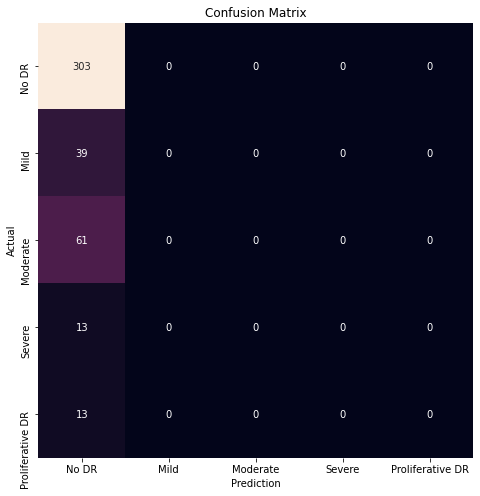

In [65]:
fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_tuner, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

In [66]:
#Save the model
model.save('CNN5_Tuner.h5')